# DATA SCIENCE SESSIONS VOL. 3
### A Foundational Python Data Science Course
## Session 15: Regularization in MLR. The Maximum Likelihood Estimation (MLE).

[&larr; Back to course webpage](https://datakolektiv.com/)

Feedback should be send to [goran.milovanovic@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com). 

These notebooks accompany the DATA SCIENCE SESSIONS VOL. 3 :: A Foundational Python Data Science Course.

### Lecturers

[Goran S. Milovanović, PhD, DataKolektiv, Chief Scientist & Owner](https://www.linkedin.com/in/gmilovanovic/)

[Aleksandar Cvetković, PhD, DataKolektiv, Consultant](https://www.linkedin.com/in/alegzndr/)

[Ilija Lazarević, MA, DataKolektiv, Consultant](https://www.linkedin.com/in/ilijalazarevic/)

***
Let's first import all of the necessary libraries for later.

In [1]:
### --- Setup - importing the libraries

# - supress those annoying 'Future Warning'
import warnings
warnings.simplefilter(action='ignore')


# - data
import numpy as np
import pandas as pd

# - os
import os

# - ml
from scipy.stats import norm
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor


# - visualization
import matplotlib.pyplot as plt
import seaborn as sns

# - sklearn
from sklearn import linear_model
from sklearn.linear_model import LinearRegression

# - parameters
%matplotlib inline
pd.options.mode.chained_assignment = None  # default='warn'
sns.set_theme()

# - rng
rng = np.random.default_rng(seed=513)

# - plots
plt.rc("figure", figsize=(8, 6))
plt.rc("font", size=14)
sns.set_theme(style='white')

# - directory tree
data_dir = os.path.join(os.getcwd(), '_data')

## 0. The Problem of Overfitting

Overfitting is a common problem in machine learning where a model learns to fit the training data too closely, leading to poor performance on new or unseen data. In other words, the model becomes too complex and starts to memorize the training data instead of learning the underlying patterns and relationships.

Overfitting occurs when a model is trained on a limited set of data, and the model is too complex, with too many parameters or features, to generalize to new data. This can lead to a model that performs very well on the training data but poorly on new data.

Overfitting can be identified by comparing the model's performance on the training data to its performance on a validation set or test data. If the model performs significantly better on the training data than on the validation set, then it is likely overfitting.

To prevent overfitting, one can use techniques such as regularization, early stopping, or reducing the complexity of the model. Regularization techniques, such as L1 or L2 regularization, can penalize the model for having too many features or high parameter values, while early stopping can stop the training process before the model starts to overfit. Additionally, reducing the complexity of the model, such as by decreasing the number of features or using a simpler model architecture, can also help prevent overfitting.

Let's, for the sake of the example, generate a sample of bivariate distribution.

In [2]:
x = norm.rvs(loc=15,scale=10,size=100)
# y is a noisy linear transformation of x:

y_linear = norm.rvs(loc=10,scale=7,size=100)


# set intercept and slope
intercept_y = 7.5
slope_y = .78

y= intercept_y + x*slope_y + y_linear
data = pd.DataFrame({'x':x,'y':y})
data

,x,y
0,31.312004,38.941688
1,6.710060,22.741886
2,11.969767,25.164092
3,12.029652,22.834869
4,6.346574,21.498562
...,...,...
95,19.194734,31.015952
96,-8.169652,6.996615
97,17.522318,39.785460
98,14.556360,23.039689


Now, shall we plot values of *y* as a function of *x*?

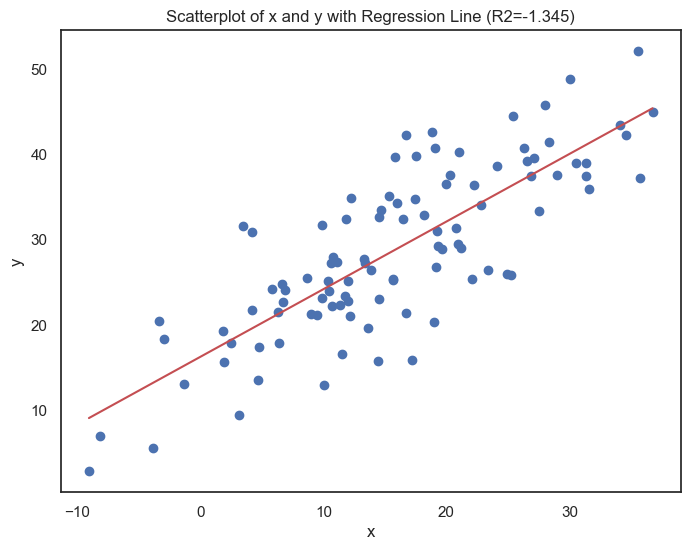

In [3]:
# create a scatterplot of x and y

plt.scatter(data[['x']],data['y'])

# create a linear regression model

lr = LinearRegression()
lr.fit(data[['x']],data['y'])

# create a range of x values to plot the regression line

x_range = np.linspace(data[['x']].min(),data[['x']].max(),100)
x_range.shape

# predict y values using the linear regression model and x_range values

y_pred = lr.predict(x_range)

# add the regression line to the scatterplot

plt.plot(x_range,y_pred,c='r')

#r2 score

from sklearn.metrics import r2_score

r2sc= r2_score(data['y'],y_pred)
# add labels and title to the plot
plt.xlabel('x')
plt.ylabel('y')
plt.title(f'Scatterplot of x and y with Regression Line (R2={r2sc:.3f})')

# show the plot
plt.show()

This is all fine. However, how about we decalare this bivariate distribution as a population, and sample 10k samples of 100 observations and do the same thing i.e. get the intercept and slope parameters for this linear model.

We will store parameter values with the value of R2, in dedicated *Pandas* DataFrame for easier display.

In [4]:
data['R2'] = r2sc
data

,x,y,R2
0,31.312004,38.941688,-1.344571
1,6.710060,22.741886,-1.344571
2,11.969767,25.164092,-1.344571
3,12.029652,22.834869,-1.344571
4,6.346574,21.498562,-1.344571
...,...,...,...
95,19.194734,31.015952,-1.344571
96,-8.169652,6.996615,-1.344571
97,17.522318,39.785460,-1.344571
98,14.556360,23.039689,-1.344571


Oh the new one.

In [60]:
data_v2 = pd.DataFrame(columns=['beta_0','beta_1','R2'])
data_v2

,beta_0,beta_1,R2


In [61]:
# perform 10000 linear regressions on samples of size 1000

for i in range(100):
    # take a sample of size 100 without replacement
    sample = data.sample(n=100, replace=False)        
    # perform linear regression on the sample
    lr = LinearRegression()
    lr.fit(sample[['x']],sample['y'])
    beta_0 = lr.intercept_
    beta_1 = lr.coef_[0]
    r2 = r2_score(sample[['x']],sample['y'])
    data_v2.loc[i] = [beta_0,beta_1,r2]

In [62]:
#or create an emtpy list

results = []

for i in range(100):
    sample=data.sample(n=100,replace=False)

    lr=LinearRegression()
    lr.fit(sample[['x']],sample['y'])
    intercept = lr.intercept_
    beta_1 = lr.coef_[0]
    r2score = r2_score(sample[['x']],sample['y'])
    results = [intercept,beta_1,r2score]
    results.append(data_v2)
data_v2


,beta_0,beta_1,R2
0,16.288904,0.792319,-1.095079
1,16.288904,0.792319,-1.095079
2,16.288904,0.792319,-1.095079
3,16.288904,0.792319,-1.095079
4,16.288904,0.792319,-1.095079
...,...,...,...
95,16.288904,0.792319,-1.095079
96,16.288904,0.792319,-1.095079
97,16.288904,0.792319,-1.095079
98,16.288904,0.792319,-1.095079


What is the distribution of R2 metric for all of the samples?

array([[<Axes: title={'center': 'R2'}>]], dtype=object)

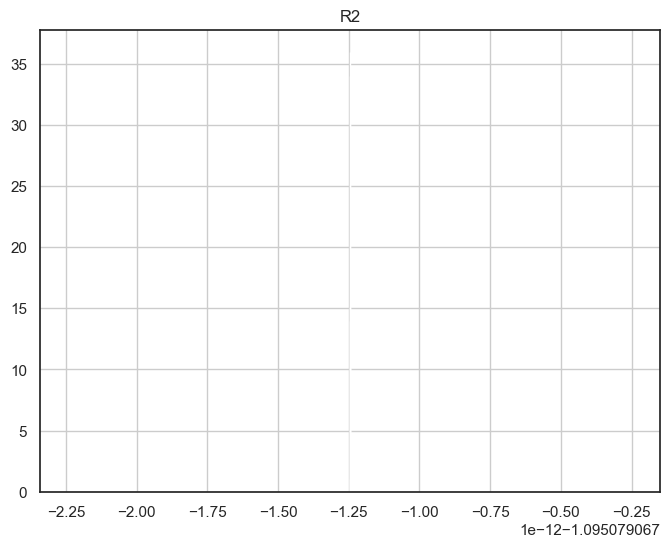

In [51]:
data_v2.hist('R2',bins=100)

And how did each of linear regression models look like? Here are the first 12 samples linear regression models, with observations.

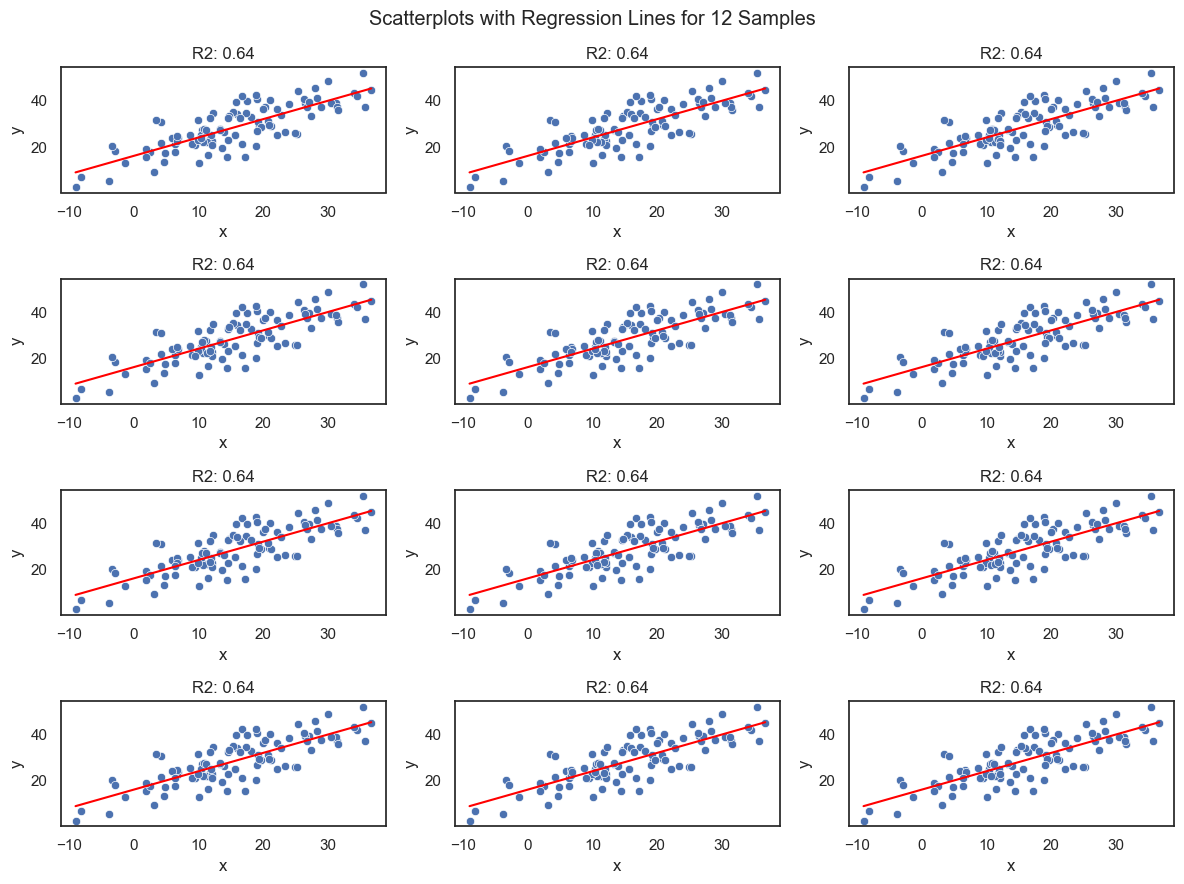

In [63]:
# take 12 random samples of size 1000 without replacement
samples = [data.sample(n=100, replace=False) for i in range(12)]

# create a 4 x 3 grid of subplots
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(12, 9))

# loop through each subplot and plot the scatterplot and regression line for one sample
for i, ax in enumerate(axes.flat):
    # perform linear regression on the sample
    lr = LinearRegression()
    lr.fit(samples[i][['x']], samples[i]['y'])
    
    # plot the scatterplot
    sns.scatterplot(x='x', y='y', data=samples[i], ax=ax)
    
    # plot the regression line
    sns.lineplot(x=samples[i]['x'], y=lr.predict(samples[i][['x']]), color='red', ax=ax)
    
    # set the title of the subplot to the R2 score
    ax.set_title('R2: {:.2f}'.format(lr.score(samples[i][['x']], samples[i]['y'])))
    
# set the overall title of the plot
fig.suptitle('Scatterplots with Regression Lines for 12 Samples')

# adjust the spacing between subplots
plt.tight_layout()

# show the plot
plt.show()

Note how for each sample intercepts and slopes are different, and how R2 is also varying. Why? We have sampled from the same 'population'.

## 1. Regularization in Multiple Linear Regression

### 1.1 Lasso (L1), Ridge (L2), and Elastic Net regression

Regularization is used for several purposes: 

- it helps reduce the problem of multicollinearity in Linear Regression,
- it is used as method of **feature selection** in large models, and 
- it is used as a method to prevent overfitting.

Consider the following:

$$Loss = \sum_{i=1}^{n}{\big(y_i-\hat{y_i}\big)^2}$$

It is just the ordinary sum of squares, or the **loss** (or **cost**) function of the Linear Regression Model. The parameters $\beta$ of the Linear Model are estimate by minimizing the above quantity - the model's *cost function*. The expression above is just the ordinary $SSE$ function as we have encountered it before in our sessions on Linear Regression.

Now, consider the following formulation of the cost function that includes the *penalty term*:

$$Loss_{L2} = \sum_{i=1}^{n}{\big(y_i-\hat{y_i}\big)^2}+\lambda\sum_{j=1}^{p}\beta_j^2$$

$\lambda\sum_{j=1}^{p}\beta_j^2$ is the *penalty term*: it increases the value of the cost function by a factor determined by the sum of the squared model coefficients. In the expression above $p$ stands for the number of model parameters (coefficients, in the case of Linear Regression) and $\beta$ are the coefficients themselves. The above expression represents the $L2$ regularization for the Linear Model, also known as **Ridge Regression**. If $\lambda$ is zero we get back to the Ordinary Least Squares model that we have already learned about. If $\lambda$ is too large, it will add too much weight to the cost function which will lead to *underfitting*. 

The underlying idea is to *penalize* large coefficients: it *regularizes* the coefficients so that if they take large values the cost function is penalized. In effect, the Ridge regression shrinks the coefficients so to reduce the model complexity and reduces the effects multicollinearity.

Consider now the following modification of the cost function:

$$Loss_{L1} = \sum_{i=1}^{n}{\big(y_i-\hat{y_i}\big)^2}+\lambda\sum_{j=1}^{p}|\beta_j|$$

The above cost function is based on a weighted sum of the *absolute* values of the model coefficients. This approach is known as $L1$ or **Lasso Regression**. 

The most important **difference between Ridge and Lasso regularization** is that in Lasso some coefficients can be *shrinked to zero* and get completely eliminated from the model. Thus, Lasso regularization does not only prevent overfitting but also performs **feature selection** - a very handy thing when considering large linear models. 

Finally, consider the following formulation of a loss (or cost) function:

$$Loss_{ElasticNet} = \frac{\sum_{i=1}^{n}(y_i-\hat{y_i})^2}{2n}+\lambda(\frac{1-\alpha}{2}\sum_{j=1}^{m}\hat{\beta_j}^2+\alpha\sum_{j=1}^{m}|\hat{\beta_j}|)$$

In the expression above - the **Elastic Net** regression - $\alpha$ is the *mixing parameter* between Lasso ($\alpha=1$) and Ridge ($\alpha=0$) approach. While the Ridge regression shrinks the coefficients of correlated predictors towards each other, the Lasso regression tends to pick one of them and decrease the others. The Elastic Net penalty is a mixture of the two approaches controlled by $\alpha$.

### 1.2 Inspect Multicolinearity in one particular Linear Regression problem

Here we are going to use King County, Washington State, USA housing data set. It is good for predicting house prices using MLR (multiple linear regression).

In [64]:
data_set = pd.read_csv(os.path.join(data_dir, 'kc_house_data.csv'))
data_set.head(10)

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
5,7237550310,20140512T000000,1225000.0,4,4.50,5420,101930,1.0,0,0,...,11,3890,1530,2001,0,98053,47.6561,-122.005,4760,101930
6,1321400060,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
7,2008000270,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711
8,2414600126,20150415T000000,229500.0,3,1.00,1780,7470,1.0,0,0,...,7,1050,730,1960,0,98146,47.5123,-122.337,1780,8113
9,3793500160,20150312T000000,323000.0,3,2.50,1890,6560,2.0,0,0,...,7,1890,0,2003,0,98038,47.3684,-122.031,2390,7570


What is the nature of our data set?

In [66]:
data_set.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

#### Target: predict price from the numerical predictors

Let's use just subset of all given variables as predictors.

In [83]:

# - for the simplicity we will drop some variables from the dataset

model_frame = data_set.drop(columns=['id', 'lat', 'long', 'date',
                                      'zipcode', 'yr_renovated', 'waterfront',
                                      'view', 'sqft_basement'])

model_frame.info() # only the numerical's left
model_frame

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   condition      21613 non-null  int64  
 7   grade          21613 non-null  int64  
 8   sqft_above     21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  sqft_living15  21613 non-null  int64  
 11  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 2.0 MB


,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,1800,7503
...,...,...,...,...,...,...,...,...,...,...,...,...
21608,360000.0,3,2.50,1530,1131,3.0,3,8,1530,2009,1530,1509
21609,400000.0,4,2.50,2310,5813,2.0,3,8,2310,2014,1830,7200
21610,402101.0,2,0.75,1020,1350,2.0,3,7,1020,2009,1020,2007
21611,400000.0,3,2.50,1600,2388,2.0,3,8,1600,2004,1410,1287


We have to exclude predicted (target) variable from the training data set.

In [90]:
predictors = model_frame.columns.drop('price')
predictors

Index(['bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'condition', 'grade', 'sqft_above', 'yr_built', 'sqft_living15',
       'sqft_lot15'],
      dtype='object')

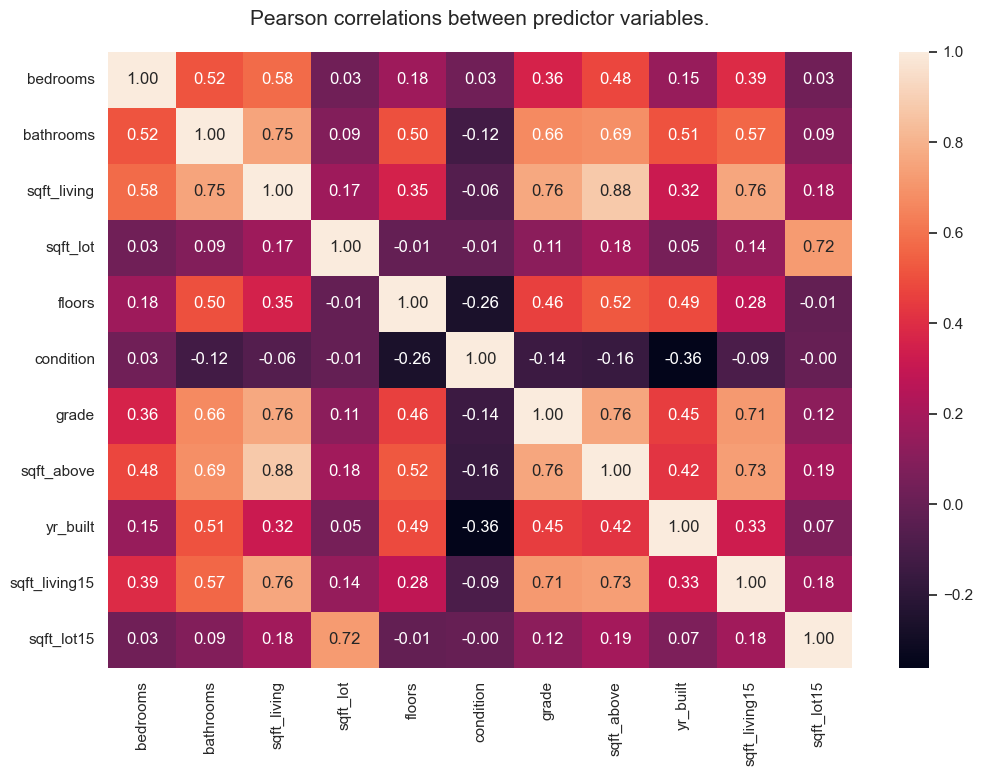

In [98]:
# - the correlations of the predictors
plt.figure(figsize=(12,8))
sns.heatmap(model_frame[predictors].corr(),annot=True,fmt='.2f')
plt.title('Pearson correlations between predictor variables.', size=15, y=1.03);

Let's define *formula* for our model by introducing chosen variables names.

In [104]:
formula = ' + '.join(predictors)
formula = 'price ~ ' + formula
formula

'price ~ bedrooms + bathrooms + sqft_living + sqft_lot + floors + condition + grade + sqft_above + yr_built + sqft_living15 + sqft_lot15'

And now fit the model using OLS.

In [109]:
# - fitting the linear model to the data
mlr = smf.ols(formula=formula, data=model_frame).fit()
mlr.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.620
Model:                            OLS   Adj. R-squared:                  0.620
Method:                 Least Squares   F-statistic:                     3202.
Date:                Fri, 18 Apr 2025   Prob (F-statistic):               0.00
Time:                        17:51:59   Log-Likelihood:            -2.9715e+05
No. Observations:               21613   AIC:                         5.943e+05
Df Residuals:                   21601   BIC:                         5.944e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      6.933e+06   1.36e+05     51.002      0.000    6.67e+06     7.2e+06
bedrooms      -4.936e+04   2108.805    -23.406      0.000   -5.35e+04   -4.52e+04
bathrooms       5.01e+04   3625.970     13.817      0.000     4.3e+04    5.72e+04
sqft_living     195.1515      4.812     40.552      0.000     185.719     204.584
sqft_lot          0.0111      0.054      0.207      0.836      -0.094       0.116
floors         3.348e+04   3957.258      8.461      0.000    2.57e+04    4.12e+04
condition      1.898e+04   2580.038      7.356      0.000    1.39e+04     2.4e+04
grade          1.246e+05   2346.774     53.099      0.000     1.2e+05    1.29e+05
sqft_above      -28.6643      4.678     -6.128      0.000     -37.833     -19.496
yr_built      -3968.3906     69.774    -56.875      0.000   -4105.152   -3831.629
sqft_living15    36.2656      3.735      9.709      0.000      28.944      43.587
sqft_lot15       -0.5066      0.082     -6.172      0.000      -0.667      -0.346
==============================================================================
Omnibus:                    17771.672   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1362466.098
Skew:                           3.467   Prob(JB):                         0.00
Kurtosis:                      41.274   Cond. No.                     4.47e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.47e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [110]:
# - R^2 of the linear model
mlr.rsquared

0.6198708417378094

It is always good to include **VIF** information for variables, just for better overview.

In [114]:
#VIFs 
# - computing VIFs
model_frame_predictors = sm.add_constant(model_frame[predictors])
vifs = [variance_inflation_factor(model_frame_predictors.values, i) for i in range(1, len(predictors)+1)]
vifs = np.array(vifs).reshape(1, -1)
vifs
pd.DataFrame(vifs, columns=predictors)

,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,1.621833,3.287936,8.236167,2.085978,1.925165,1.188449,3.208241,6.325912,1.770933,2.763124,2.117307


### 1.3 Regularization of the model coefficients: Ridge (L2) Regularization

Now we are going to use scikit-learn to perform *Regularized* Multiple Linear Regression; we'll be using the Ridge Regression. 

As we have see, the Ridge Regression model is obtained by minimizing the function

$$SSE + \alpha L_2^2,$$

where $SSE$ is the Sum Squarred Error of the 'ordinary' Multiple Linear Regression 

$$\hat{y} = \beta_1x_1 + \beta_2x_2 + \cdots + \beta_kx_k + \beta_0,$$

and $L_{2}^2$ is the squared $L_{2}-$ norm of Multiple Linear Regression model parameters $\beta_1,\beta_2,\ldots,\beta_k$:

$$L_2^2 = \beta_1^2 + \beta_2^2 + \cdots + \beta_k^2,$$

and hence the name **L2 Regularization**. $\alpha$ is called *penalization (hyper)parameter*, and it's used to control the magnitude of models parameters; for $\alpha = 0$ we recover ordinary MLR.

In [115]:
model_frame.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,condition,grade,sqft_above,yr_built,sqft_living15,sqft_lot15
0,221900.0,3,1.00,1180,5650,1.0,3,7,1180,1955,1340,5650
1,538000.0,3,2.25,2570,7242,2.0,3,7,2170,1951,1690,7639
2,180000.0,2,1.00,770,10000,1.0,3,6,770,1933,2720,8062
3,604000.0,4,3.00,1960,5000,1.0,5,7,1050,1965,1360,5000
4,510000.0,3,2.00,1680,8080,1.0,3,8,1680,1987,1800,7503


In [116]:
# - checking if all the variables are numerical
model_frame.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   price          21613 non-null  float64
 1   bedrooms       21613 non-null  int64  
 2   bathrooms      21613 non-null  float64
 3   sqft_living    21613 non-null  int64  
 4   sqft_lot       21613 non-null  int64  
 5   floors         21613 non-null  float64
 6   condition      21613 non-null  int64  
 7   grade          21613 non-null  int64  
 8   sqft_above     21613 non-null  int64  
 9   yr_built       21613 non-null  int64  
 10  sqft_living15  21613 non-null  int64  
 11  sqft_lot15     21613 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 2.0 MB


Split data into two parts, predictor and predicted variable data sets.

In [ ]:
# - feature matrix
X = model_frame[predictors].values

# - target vector
y = model_frame['price'].values


(21613, 11)

Now we are fitting sklearn's *Ridge* model, for Ridge regression. 

In [120]:
### --- Fitting a Ridge MLR Regularized model on the given data, with the penalization parameter \alpha = 10^4
mlr_ridge = linear_model.Ridge(alpha=1e+4)
mlr_ridge.fit(X, y)

Ridge(alpha=10000.0)

In [121]:
# - model intercept
mlr_ridge.intercept_

5945635.344976564

In [122]:
# - model coefficients; the order corresponds to the order of coefficients given by the statsmodel 'ordinary' MLR
mlr_ridge.coef_

array([-2.91771401e+04,  1.81662857e+04,  2.26257901e+02,  1.41002993e-02,
        1.59074953e+04,  7.12968872e+03,  6.53923517e+04, -5.50894014e+00,
       -3.28129969e+03,  6.05780655e+01, -6.44587129e-01])

In [123]:
# - R^2 score of the Ridge Regularization
mlr_ridge.score(X, y)

0.6013062798111166

In [124]:
### --- Varying the penalization parameter for the Ridge Regularized Model
n_alphas = 200
alphas = np.logspace(-2, 10, n_alphas)

coefs = []
scores = []
mserrs = []
l2_norms = []
for a in alphas:
    # - fitting a Ridge Regularization
    ridge = linear_model.Ridge(alpha=a)
    ridge.fit(X, y)
    
    # - R^2 score of a fitted Regularized Model
    R2 = ridge.score(X, y)
    
    # - MSE of a model
    mse = np.mean((y - ridge.predict(X))**2)
    
    # - squared L2 norm of model coefficients
    l2 = np.linalg.norm(ridge.coef_, ord=2)**2
    
    coefs.append(ridge.coef_)
    scores.append(R2)
    mserrs.append(mse)
    l2_norms.append(l2)

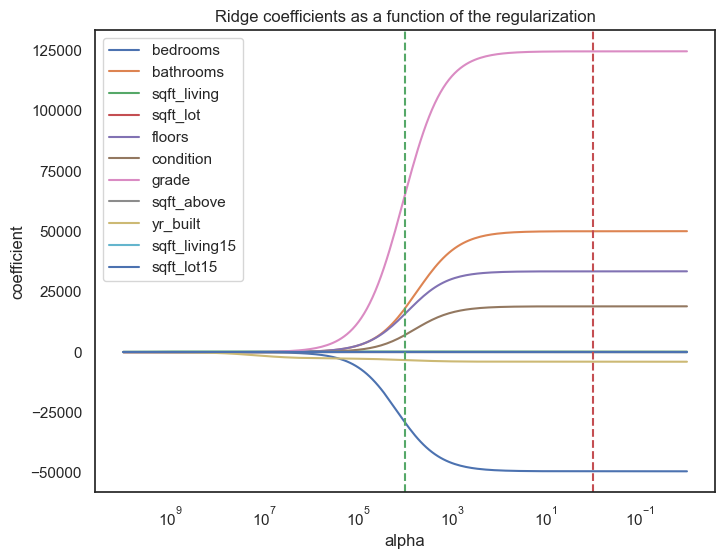

In [125]:
### --- Plotting the dependence of model parameters vs. the penalization parameter
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to \alpha = 1
ax.axvline(x=10000, c='g', ls='--') # green line, corresponding to \alpha = 10^4
plt.xlabel("alpha")
plt.ylabel("coefficient")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

And what about how scaling *alpha* affects $L_2$ norm, MSE and R2 scores?

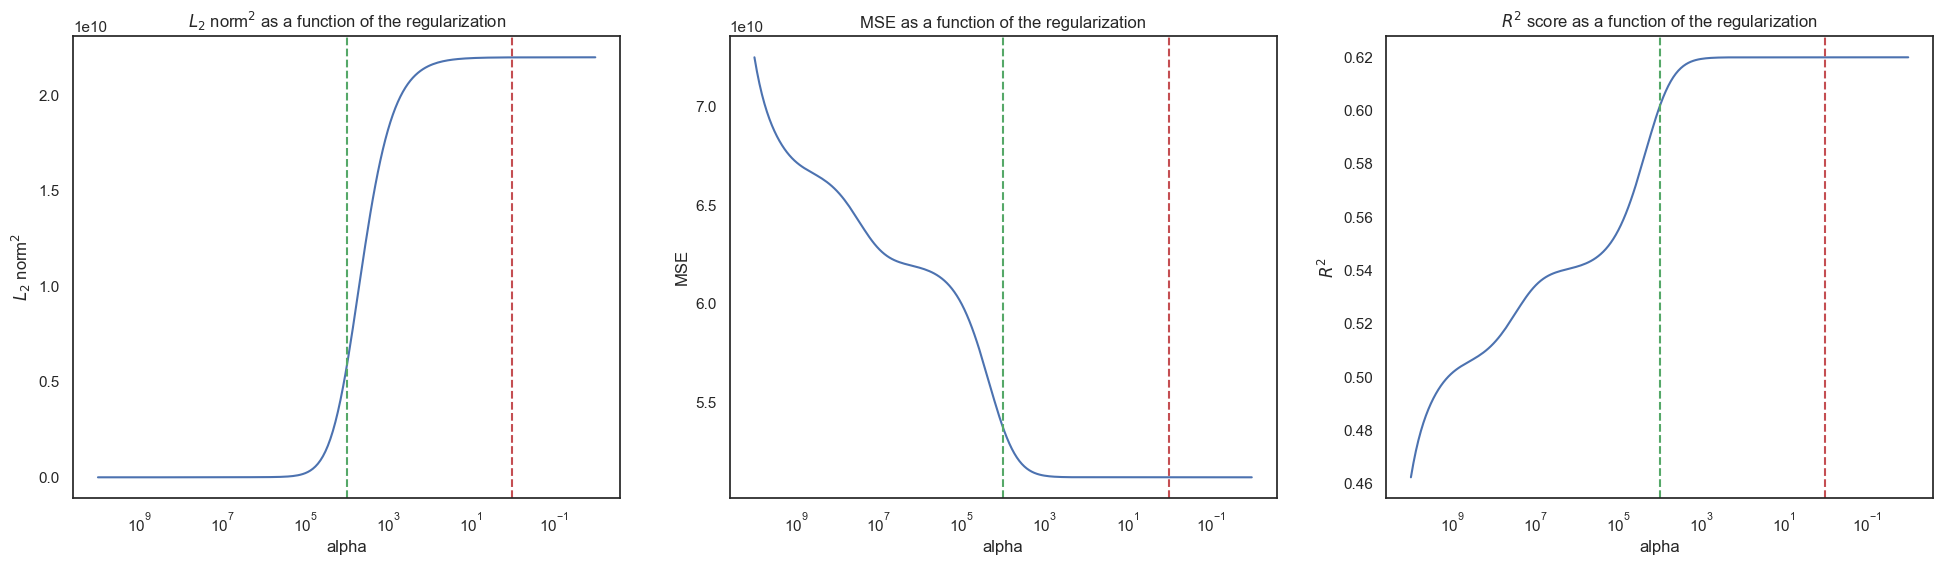

In [126]:
### --- Plotting the dependance of various model metrics vs. the penalization hyperparameter
ig, ax = plt.subplots(1, 3, figsize=(24, 6), sharex=True)


# - squared L2-norm vs. \alpha
ax[0].plot(alphas, l2_norms)
ax[0].set_xscale("log")
ax[0].set_xlim(ax[0].get_xlim()[::-1])  # reverse axis
ax[0].axvline(x=1, c='r', ls='--') # red line
ax[0].axvline(x=10000, c='g', ls='--') # green line
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("$L_2$ norm$^2$")
ax[0].set_title("$L_2$ norm$^2$ as a function of the regularization")
ax[0].axis("tight")

# - MSE vs. \alpha
ax[1].plot(alphas, mserrs)
ax[1].set_xscale("log")
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].axvline(x=10000, c='g', ls='--') # green line
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("MSE")
ax[1].set_title("MSE as a function of the regularization")
ax[1].axis("tight")

# - R^2 vs. \alpha
ax[2].plot(alphas, scores)
ax[2].set_xscale("log")
ax[2].axvline(x=1, c='r', ls='--') # red line
ax[2].axvline(x=10000, c='g', ls='--') # green line
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("$R^2$")
ax[2].set_title("$R^2$ score as a function of the regularization")
ax[2].axis("tight");

### 1.4 LASSO (L1) Regularization

*LASSO* is another way to regularize MLR model. It's obtained by minimizing the function

$$SSE + \alpha L_1,$$

where $SSE$ is Sum Squared Error of the ordinary Multiple Linear Regression and $L_1$ is $L_1-$ norm of its coeffitents given by

$$L_1 = |\beta_1| + |\beta_2| + \cdots + |\beta_k|,$$

and hence the name **L1 Regularization**. $\alpha$ is, of course, penalization hyperparameter. 

Here we are using sklearn's *LASSO* model, for Lasso regularized model.

In [127]:
### --- Varying the penalization parameter for the LASSO Regularized Model
n_alphas = 200
alphas = np.logspace(-2, 10, n_alphas)

coefs = []
scores = []
mserrs = []
l1_norms = []
for a in alphas:
    # - fitting a LASSO Regularization
    lasso = linear_model.Lasso(alpha=a)
    lasso.fit(X, y)
    
    # - R^2 score of a fitted Regularized Model
    R2 = lasso.score(X, y)
    
    # - MSE of a model
    mse = np.mean((y - lasso.predict(X))**2)
    
    # - L1 norm of model coefficients
    l1 = np.linalg.norm(lasso.coef_, ord=1)
    
    coefs.append(lasso.coef_)
    scores.append(R2)
    mserrs.append(mse)
    l1_norms.append(l1)

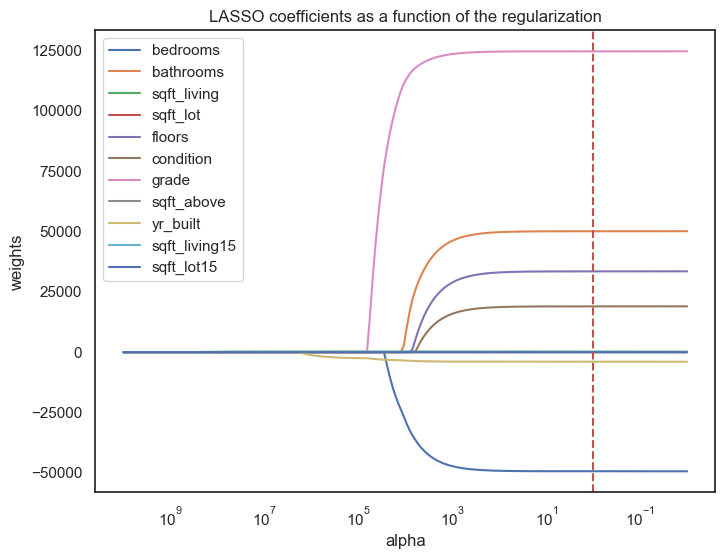

In [128]:
### --- Plotting the dependence of model parameters vs. the penalization parameter
ax = plt.gca()

ax.plot(alphas, coefs)
ax.set_xscale("log")
ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis, 
ax.axvline(x=1, c='r', ls='--') # red line, corresponding to \alpha = 1
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("LASSO coefficients as a function of the regularization")
plt.axis("tight")
plt.legend(predictors)
plt.show()

And what about how scaling *alpha* affects $L_2$ norm, MSE and R2 scores?

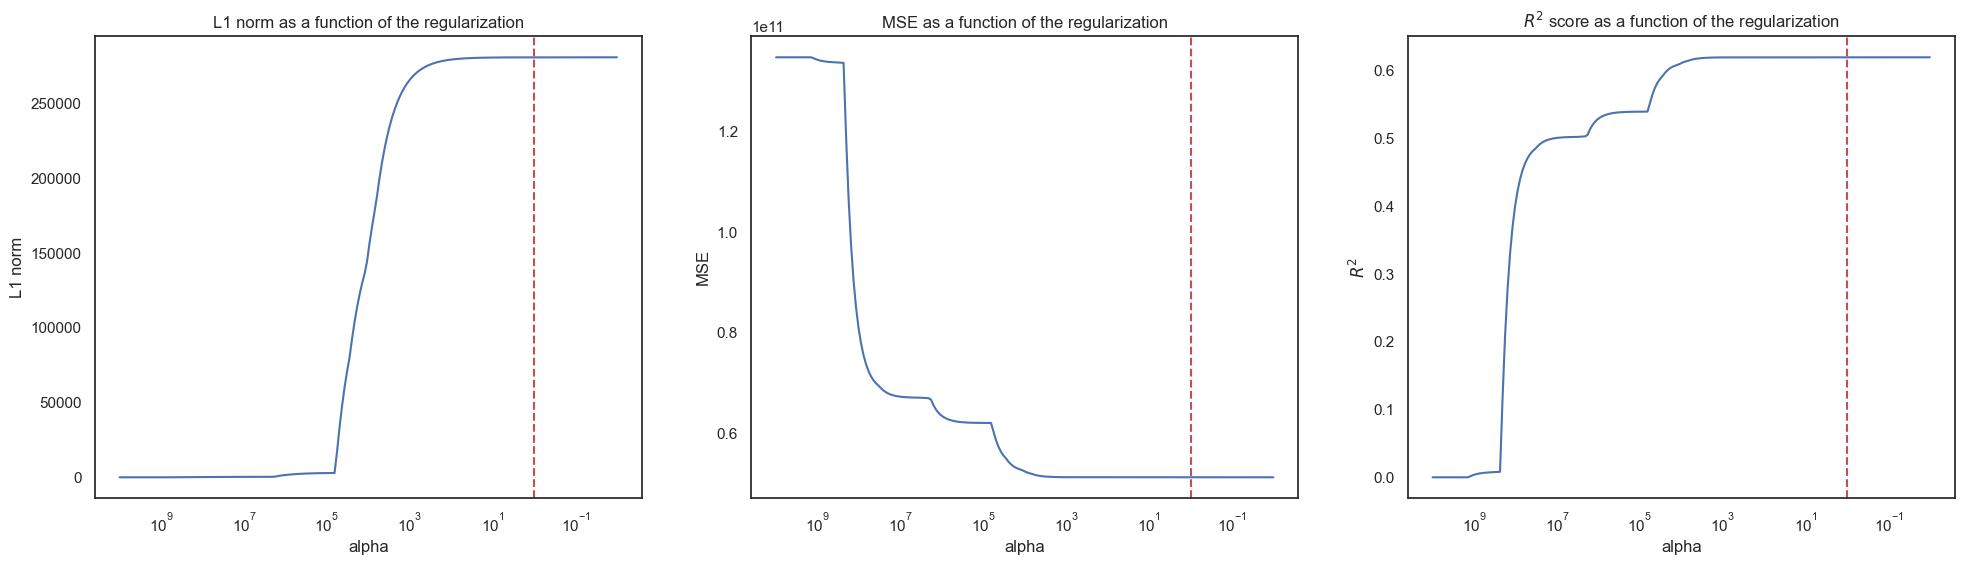

In [129]:
### --- Plotting the dependance of various model metrics vs. the penalization hyperparameter
ig, ax = plt.subplots(1, 3, figsize=(24, 6), sharex=True)

# - L1-norm vs. \alpha
ax[0].plot(alphas, l1_norms)
ax[0].set_xscale("log")
ax[0].set_xlim(ax[0].get_xlim()[::-1])  # reverse axis
ax[0].axvline(x=1, c='r', ls='--') # red line
ax[0].set_xlabel("alpha")
ax[0].set_ylabel("L1 norm")
ax[0].set_title("L1 norm as a function of the regularization")
ax[0].axis("tight")

# - MSE vs. \alpha
ax[1].plot(alphas, mserrs)
ax[1].set_xscale("log")
ax[1].axvline(x=1, c='r', ls='--') # red line
ax[1].set_xlabel("alpha")
ax[1].set_ylabel("MSE")
ax[1].set_title("MSE as a function of the regularization")
ax[1].axis("tight")

# - R^2 vs. \alpha
ax[2].plot(alphas, scores)
ax[2].set_xscale("log")
ax[2].axvline(x=1, c='r', ls='--') # red line
ax[2].set_xlabel("alpha")
ax[2].set_ylabel("$R^2$")
ax[2].set_title("$R^2$ score as a function of the regularization")
ax[2].axis("tight");

We see that the best model is obtained with small penalization hyperparameter, i.e. with big model parameters values.

Maximum Likelihood Estimation (MLE) is yet another approach in estimating model parameters. It is a way of estimating the parameter(s) of probability distribution that generated the sample that we have at hand. Before showing the examples of how parameters values are estimated using MLE, let's refresh some of the things we talked about during the session 11.

Back then, we have introduced something that is called *Bayes' Theorem*. Given that we have two events $A$ and $B$, and given that $P(A)\neq0$ we can define:

$$ P(B|A) = \frac{P(A|B)P(B)}{P(A)}.$$

Also, we said that $P(A|B)$ is also called *likelihood*, and introduced another way of naming it. Namely $\mathcal{L}(B|A)$. If you remember we said that:

$$\mathcal{L}(B|A) = P(A|B).$$

So, the likelihood of the event $B$ occuring given that the event $A$ has occured is equal to the conditional probability of event $A$ occuring under the condition that the event $B$ has occured.


If we speak in terms of random varable and distribution parameters we usually write:

$$P(\theta; X) = \frac{\mathcal{L}(\theta; X)P(\theta)}{P(X)}$$

and 

$$\mathcal{L}(\theta; X) = P(X; \theta).$$

where $X$ is RV and $\theta$ are its distributions' parameters (when there is a single parameter $\theta$ is scallar, and when there are multiple parameters ${\theta}$ is a vector).


Now, imagine we have RV $X$ sample of 3 observations $x_1, x_2, x_3$. In this case, previously rewritten Bayes' Theorem would be:

$$P(\theta; x1, x2, x3) = \frac{\mathcal{L}(\theta; x_1, x_2, x_3)P(\theta)}{P(x_1, x_2, x_3)}.$$

If we focus just on $\mathcal{L}(\theta; x_1, x_2, x_3)$ term, and use already defined equality $\mathcal{L}(\theta; X) = P(X; \theta)$, knowing that $x_1, x_2$ and $x_3$ are statistically independent, we have:

$$\mathcal{L}(\theta; x_1, x_2, x_3) = P(x_1, x_2, x_3; \theta) = P(x_1; \theta) * P(x_2; \theta) * P(x_3; \theta). $$

In general, if we have the sample of N observations, we have:

$$\mathcal{L}(\theta; x_1, x_2,..., x_N) = \prod_{i=1}^{N}{P(x_i; \theta)}. $$ 

This multiplication can easily get computationally intractable in practice. This is the reason why we define *log-likelihood* as:

$$\mathcal{l}(\theta; x_1, x_2,..., x_N) = log(\prod_{i=1}^{N}{P(x_i; \theta)}) = \sum_{i=1}^{N}{log(P(x_i; \theta))}.$$

This works because the logarithm is a strictly increasing function, and by maximizing the *log-likelihood* we are in essence maximizing *likelihood*.

And now, the examples.


### Tossing a coin

Imagine I have a **fair coin**: the one that lands Heads and Tails with equal probabilities P(H) = P(T) = 1/2.

In [131]:
tosses = np.array([1,0,1,0,1,0,0,1,0,0])
print(tosses)

[1 0 1 0 1 0 0 1 0 0]


In [132]:
np.unique(tosses, return_counts=True)[1]

array([6, 4], dtype=int64)

Uhm, but I have already *assumed* that we will be tossing a fair coin? Four heads, six tails, how come? Is this really a fair coin? The answer is: it still might be. Let's see.

In [133]:
outcomes = np.array([0,1])
tosses = np.random.choice(outcomes, 10, replace=True, p=[.5, .5])
print(tosses)
print(np.unique(tosses, return_counts=True)[1]/tosses.size)

[0 0 0 0 1 0 0 1 0 1]
[0.7 0.3]


What about now?

In [134]:
outcomes = np.array([0,1])
tosses = np.random.choice(outcomes, 10, replace=True, p=[.5, .5])
print(tosses)
print(np.unique(tosses, return_counts=True)[1]/tosses.size)

[0 0 0 1 1 1 1 1 1 1]
[0.3 0.7]


Let's create 1000 samples and check the proportions of heas and tails.

In [135]:
outcomes = np.array([0,1])
num_exps = 1_000
stat_exp_1 = []

for i in range(num_exps):
    tosses = np.random.choice(outcomes, 100, replace=True, p=[.5, .5])
    result = np.array([(tosses==0).sum(), (tosses==1).sum()])/tosses.size
    result = {'P_T':result[0], 'P_H':result[1]}
    stat_exp_1.append(result)
    
stat_exp_1 = pd.DataFrame(stat_exp_1)    
stat_exp_1.head(20)

,P_T,P_H
0,0.50,0.50
1,0.51,0.49
2,0.48,0.52
3,0.51,0.49
4,0.48,0.52
5,0.53,0.47
6,0.61,0.39
7,0.52,0.48
8,0.53,0.47
9,0.39,0.61


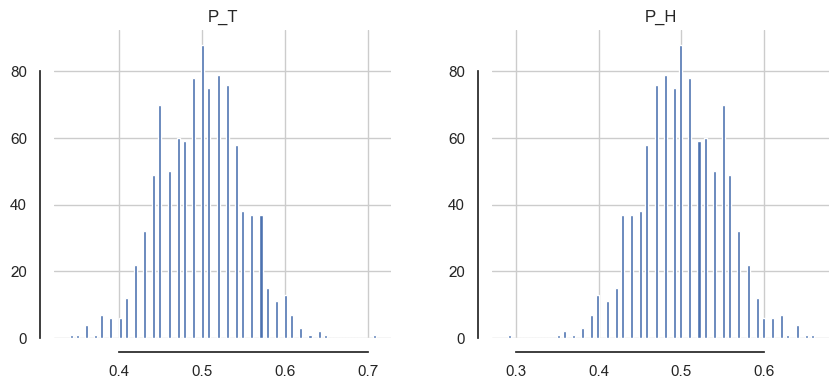

In [136]:
# - matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 4]

stat_exp_1.hist(bins=100)

sns.despine(offset=10, trim=True)

Ok, now let' see what happens with 10,000 statistical experiments with a fair coin:

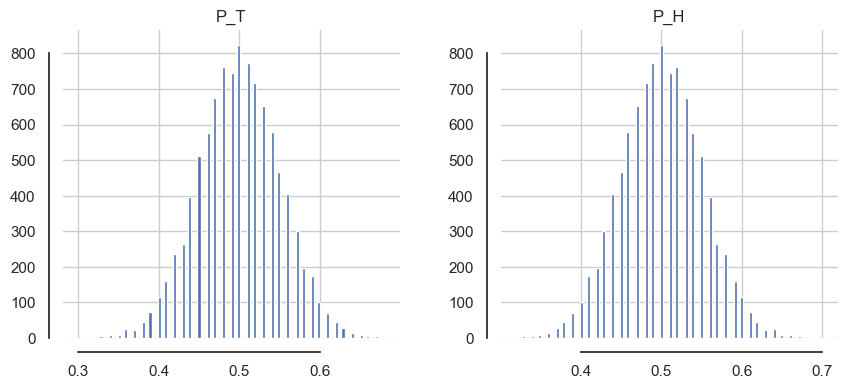

In [137]:
# - matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 4]

outcomes = np.array([0,1])
num_exps = 10_000
stat_exp_1 = []

for i in range(num_exps):
    tosses = np.random.choice(outcomes, 100, replace=True, p=[.5, .5])
    result = np.array([(tosses==0).sum(), (tosses==1).sum()])/tosses.size
    result = {'P_T':result[0], 'P_H':result[1]}
    stat_exp_1.append(result)

stat_exp_1 = pd.DataFrame(stat_exp_1)
stat_exp_1.hist(bins=100)

sns.despine(offset=10, trim=True)

What about 100,000 experiments?

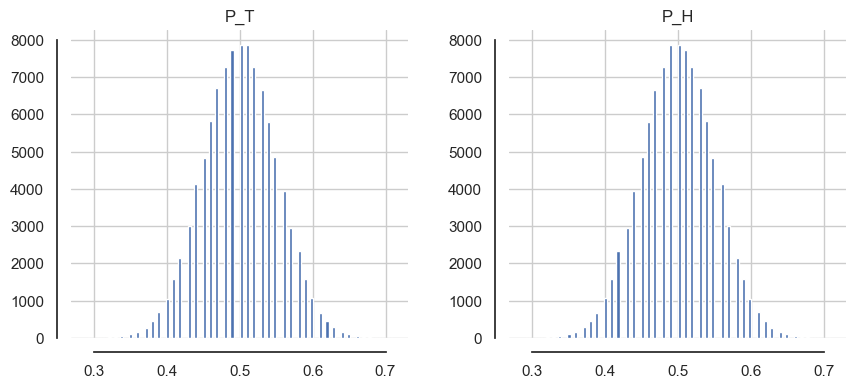

In [138]:
# - matplotlib figure size
plt.rcParams['figure.figsize'] = [10, 4]

outcomes = np.array([0,1])
num_exps = 100_000
stat_exp_1 = []

for i in range(num_exps):
    tosses = np.random.choice(outcomes, 100, replace=True, p=[.5, .5])
    result = np.array([(tosses==0).sum(), (tosses==1).sum()])/tosses.size
    result = {'P_T':result[0], 'P_H':result[1]}
    stat_exp_1.append(result)
    
stat_exp_1 = pd.DataFrame(stat_exp_1)
stat_exp_1.hist(bins=100)

sns.despine(offset=10, trim=True)

**Theoretical probability**: when we **know** that some stochastic system produces an outcome with some particular probability. 

**Experimental probability**: when we **estimate** that some stochastic system produces an outcome with some particular probability from observed data.

In [139]:
stat_exp_1['P_H'].mean()

0.5000152999999999

In [140]:
stat_exp_1['P_T'].mean()

0.4999847

### Reverse engineering the coin

In all my previous statistical experiments, I have **assumed** that the coin is fair, e.g. P(H) = P(T) = .5, look:

```
tosses = np.random.choice(outcomes, 100, replace=True, p=[.5, .5])
```

I have used numerical simulations of coin tosses to demonstrate that with increasing number of experiments I get to estimate the **known** probabilities of P(H) and P(T) better and better.

However, we typically **do not know** the theoretical probability of a random event... *Example:* the CTR of some social media post.

CTR (Click-Through Rate) is like a coin toss: a post is clicked or not clicked upon each served impression.
We can thus threat the CTR like a coin toss: P(H) = P(Clicked) is "post clicked", P(T) = P(Not clicked) is "not clicked".
Then we can say that P(Clicked) is some latent, essential characteristic of post. 

Imagine we have a set of observations for a particular social media post: 1,1,1,0,0,0,1,0,1,0,1,0,0,0,1,0.., where 1 = Clicked and 0 = Not clicked. How do we estimate the CTR of the post from these data?

Easy, right: sum up the vector of observations and divide by its length. But wait. There's more to it.

I have just invented some social media post with a CTR of .3, and estimated its experimental probability to be .3035; that is the best estimate that I currently have. What if I want to test a set of *hypotheses* about the CTR of this post? What, for example, if I am intersted to learn about the *probability of this post having a CTR of .25* instead?


Let's use a simpler, smaller set of observations to begin with.

Imagine we toss **a fair coin** with P(H)=.5 twice and observe two Heads. The probability of observing two heads with P(H)=.5 is:

`.5 * .5 = .25` 

But what if the coin was not fair, and instead had a probability of P(H)=.3? Then:

`.3 * .3 = 0.09`

And what if the coin had P(H) = .7?

`.7 * .7 = 0.49`

With P(H) = .9 we get:

`.9 * .9 = 0.81`

and it seems intuitive and logical: if we have observed a sample - *however small it was* - of all heads (and are assuming that we have observed two Heads from two tosses here), it makes sense that we are dealing with a coin that almost always lands Heads. 

Let's express this intuition visually. First, we need a function to compute the probability that a coin with a certain P(H) produced the data.

In [141]:
outcomes = np.array([0,1])
clicks = np.random.choice(outcomes, 10000, replace=True, p=[.7, .3])
ctr = np.array([(clicks==1).sum()])/clicks.size
print(ctr)

[0.3026]


Let's define a helper function for coin tossing. It is going to give us probability of observation, based on probability of getting Heads. If we say $P(H)=.2$ then each time we get Heads, function returns 0.2.

In [142]:
def parameter(observation, heads_probability):

    if observation==1:
        return heads_probability
    
    elif observation==0:
        return 1 - heads_probability
    
    else:
        return np.nan

# we are vectorizing the function
pars = np.vectorize(parameter)

# here is our sample of coin toss results
data = np.array([1, 1, 0])

# these are the probabilities of each coin toss result
print(pars(data, .25))

[0.25 0.25 0.75]


Remember that we have defined *likelihood* as multiplication of each observation's probability? Here we define function do to just that.

In [143]:
def likelihood(x, loglikelihood=False):
    if loglikelihood is True:
        return np.sum(np.log2(x))
    else:
        return np.prod(x)

In [144]:
print(likelihood(pars(data, .25)))

0.046875


In [145]:
print(likelihood(pars(data, .25), loglikelihood=True))

-4.415037499278844


In [147]:
test_parameters = np.linspace(0, 1, 1000)

# first 100 values of P(H)
print(test_parameters[0:100])

[0.         0.001001   0.002002   0.003003   0.004004   0.00500501
 0.00600601 0.00700701 0.00800801 0.00900901 0.01001001 0.01101101
 0.01201201 0.01301301 0.01401401 0.01501502 0.01601602 0.01701702
 0.01801802 0.01901902 0.02002002 0.02102102 0.02202202 0.02302302
 0.02402402 0.02502503 0.02602603 0.02702703 0.02802803 0.02902903
 0.03003003 0.03103103 0.03203203 0.03303303 0.03403403 0.03503504
 0.03603604 0.03703704 0.03803804 0.03903904 0.04004004 0.04104104
 0.04204204 0.04304304 0.04404404 0.04504505 0.04604605 0.04704705
 0.04804805 0.04904905 0.05005005 0.05105105 0.05205205 0.05305305
 0.05405405 0.05505506 0.05605606 0.05705706 0.05805806 0.05905906
 0.06006006 0.06106106 0.06206206 0.06306306 0.06406406 0.06506507
 0.06606607 0.06706707 0.06806807 0.06906907 0.07007007 0.07107107
 0.07207207 0.07307307 0.07407407 0.07507508 0.07607608 0.07707708
 0.07807808 0.07907908 0.08008008 0.08108108 0.08208208 0.08308308
 0.08408408 0.08508509 0.08608609 0.08708709 0.08808809 0.0890

In [148]:
# - setup
likelihood_frame = []
outcomes = np.array([0,1])
data = np.random.choice(outcomes, 1000, replace=True, p=[.7, .3])

# - iterate
for pr in test_parameters:
    d = likelihood(pars(data, pr))
    d = {'P_H':pr, 'Likelihood':d}
    likelihood_frame.append(d)

# - compose
likelihood_frame = pd.DataFrame(likelihood_frame)

# - inspect
likelihood_frame.head(10)

,P_H,Likelihood
0,0.000000,0.0
1,0.001001,0.0
2,0.002002,0.0
3,0.003003,0.0
4,0.004004,0.0
5,0.005005,0.0
6,0.006006,0.0
7,0.007007,0.0
8,0.008008,0.0
9,0.009009,0.0


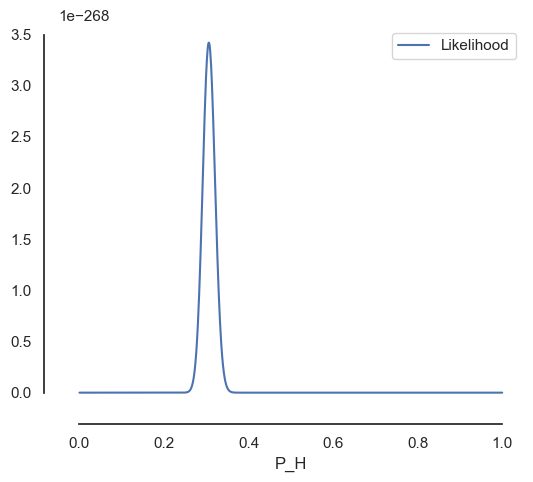

In [149]:
plt.rcParams['figure.figsize'] = [6, 5]

likelihood_frame.plot(x='P_H', y='Likelihood');

sns.despine(offset=10, trim=True)

Now for Log-Likelihood:

In [150]:
# - setup
likelihood_frame = []
outcomes = np.array([0,1])
data = np.random.choice(outcomes, 1000, replace=True, p=[.7, .3])

# - iterate
for pr in test_parameters:
    d = likelihood(pars(data, pr), loglikelihood=True)
    d = {'P_H':pr, 'Likelihood':d}
    likelihood_frame.append(d)

# - compose
likelihood_frame = pd.DataFrame(likelihood_frame)

# - inspect
likelihood_frame.head(10)

,P_H,Likelihood
0,0.000000,-inf
1,0.001001,-3000.276560
2,0.002002,-2700.287531
3,0.003003,-2525.225805
4,0.004004,-2401.312520
5,0.005005,-2305.426184
6,0.006006,-2227.267870
7,0.007007,-2161.343815
8,0.008008,-2104.374736
9,0.009009,-2054.245427


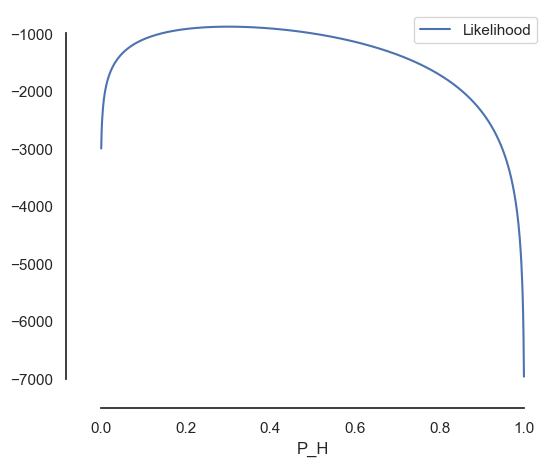

In [151]:
plt.rcParams['figure.figsize'] = [6, 5]

likelihood_frame.plot(x='P_H', y='Likelihood');

sns.despine(offset=10, trim=True)

Let's ask explicitly:

In [152]:
maximum_likelihood = likelihood_frame.idxmax()[1]

likelihood_frame['P_H'][maximum_likelihood]

0.3013013013013013

And what if P(H) was .85?

In [153]:
# - setup
likelihood_frame = []
outcomes = np.array([0,1])
data = np.random.choice(outcomes, 1000, replace=True, p=[.15, .85])

# - iterate
for pr in test_parameters:
    d = likelihood(pars(data, pr))
    d = {'P_H': pr, 'Likelihood':d}
    likelihood_frame.append(d)

# - compose
likelihood_frame = pd.DataFrame(likelihood_frame)

# - inspect
likelihood_frame.head(10)

,P_H,Likelihood
0,0.000000,0.0
1,0.001001,0.0
2,0.002002,0.0
3,0.003003,0.0
4,0.004004,0.0
5,0.005005,0.0
6,0.006006,0.0
7,0.007007,0.0
8,0.008008,0.0
9,0.009009,0.0


In [154]:
maximum_likelihood = likelihood_frame.idxmax()[1]

likelihood_frame['P_H'][maximum_likelihood]

0.8588588588588588

Pick any arbitrary observation

In [155]:
# - setup
likelihood_frame = []
data = np.array([1,1,0,1,1,1,1,1,0,0,0,0,1,1,0,1,1])

# - iterate
for pr in test_parameters:
    d = likelihood(pars(data, pr))
    d = {'P_H': pr, 'Likelihood':d}
    likelihood_frame.append(d)

# - compose
likelihood_frame = pd.DataFrame(likelihood_frame)

# - inspect
likelihood_frame.head(10)


,P_H,Likelihood
0,0.000000,0.000000e+00
1,0.001001,1.005009e-33
2,0.002002,2.045915e-30
3,0.003003,1.759043e-28
4,0.004004,4.139855e-27
5,0.005005,4.790436e-26
6,0.006006,3.537903e-25
7,0.007007,1.916616e-24
8,0.008008,8.275962e-24
9,0.009009,3.005145e-23


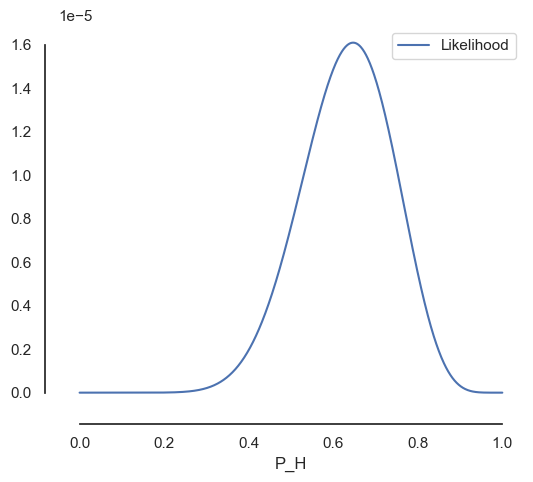

In [156]:
# - matplotlib figure size
plt.rcParams['figure.figsize'] = [6, 5]

# - plot
likelihood_frame.plot(x='P_H', y='Likelihood');

sns.despine(offset=10, trim=True)

In [157]:
maximum_likelihood = likelihood_frame.idxmax()[1]
likelihood_frame['P_H'][maximum_likelihood]

0.6466466466466466

In [158]:
np.unique(data, return_counts=True)[1]

array([ 6, 11], dtype=int64)

In [159]:
print(11/17)

0.6470588235294118


Good. What have we learned?

To estimate the parameter of a simple statistical model from data - a coin, in our case, a simple stochastic system with two outcome states only - we need to find the **maximum of its likelihood function given the observed data**.

For our example with the `HH` minimal observations - tossing a coin two times and observing two Heads in a row - the likelihood function is:

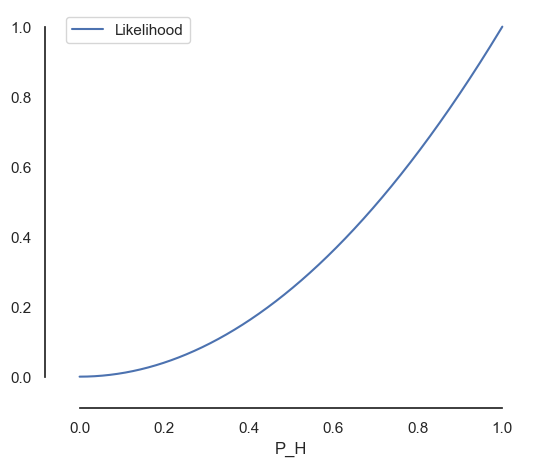

In [160]:
# - setup
likelihood_frame = []
data = np.array([1,1])

# - iterate
for pr in test_parameters:
    d = likelihood(pars(data, pr))
    d = {'P_H': pr, 'Likelihood':d}
    likelihood_frame.append(d)

# - compose
likelihood_frame = pd.DataFrame(likelihood_frame)

# - inspect
likelihood_frame.head(10)

# - matplotlib figure size
plt.rcParams['figure.figsize'] = [6, 5]

# - plot
likelihood_frame.plot(x='P_H', y='Likelihood');

sns.despine(offset=10, trim=True)


Of course: **however small the sample size**, the sample represents **just everything that we know** about a coin; if we observe all heads, like in: `HH`, then the most probable coin that could have produced the result is definitely the one that yields Heads all the time!

### 2.1 MLE in Linear Regression 

Let's use Iris data set for another example.

In [161]:
iris = pd.read_csv(os.path.join(data_dir, 'iris.csv'))
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,class
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa
5,5.4,3.9,1.7,0.4,setosa
6,4.6,3.4,1.4,0.3,setosa
7,5.0,3.4,1.5,0.2,setosa
8,4.4,2.9,1.4,0.2,setosa
9,4.9,3.1,1.5,0.1,setosa


In [162]:
linear_model = smf.ols(formula='petal_length ~ sepal_length', data=iris).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           petal_length   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.758
Method:                 Least Squares   F-statistic:                     468.6
Date:                Fri, 18 Apr 2025   Prob (F-statistic):           1.04e-47
Time:                        18:31:12   Log-Likelihood:                -190.49
No. Observations:                 150   AIC:                             385.0
Df Residuals:                     148   BIC:                             391.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
================================================================================
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -7.0954      0.506    -14.011      0.000      -8.096      -6.095
sepal_length     1.8575      0.086     21.646      0.000       1.688       2.027
==============================================================================
Omnibus:                        0.255   Durbin-Watson:                   1.204
Prob(Omnibus):                  0.880   Jarque-Bera (JB):                0.384
Skew:                          -0.084   Prob(JB):                        0.825
Kurtosis:                       2.817   Cond. No.                         43.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [163]:
iris['Prediction'] = linear_model.predict()
iris['Residuals'] = linear_model.resid
iris.head(10)

,sepal_length,sepal_width,petal_length,petal_width,class,Prediction,Residuals
0,5.1,3.5,1.4,0.2,setosa,2.377918,-0.977918
1,4.9,3.0,1.4,0.2,setosa,2.006416,-0.606416
2,4.7,3.2,1.3,0.2,setosa,1.634914,-0.334914
3,4.6,3.1,1.5,0.2,setosa,1.449163,0.050837
4,5.0,3.6,1.4,0.2,setosa,2.192167,-0.792167
5,5.4,3.9,1.7,0.4,setosa,2.935171,-1.235171
6,4.6,3.4,1.4,0.3,setosa,1.449163,-0.049163
7,5.0,3.4,1.5,0.2,setosa,2.192167,-0.692167
8,4.4,2.9,1.4,0.2,setosa,1.077661,0.322339
9,4.9,3.1,1.5,0.1,setosa,2.006416,-0.506416


Let's plot petal length as a function of sepal length.

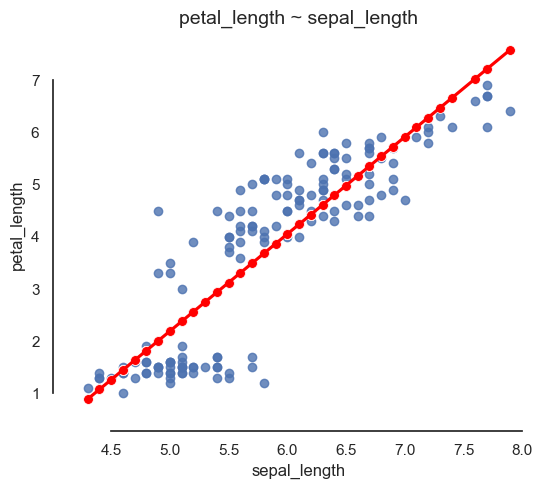

In [164]:
# - plotting the true data, predicted values and the prediction line
sns.regplot(data=iris, x='sepal_length', y='petal_length', ci=0, line_kws={'color':'red'})
sns.scatterplot(data=iris, x='sepal_length', y='Prediction', color='red', s=50)
sns.despine(offset=10, trim=True)
plt.title('petal_length ~ sepal_length', fontsize=14);

In [165]:
print("Pearson's correlation (R-value): " + str(round(np.sqrt(linear_model.rsquared), 2)))
print("Coefficient of determination (R^2): " + str(round(linear_model.rsquared, 2)))

Pearson's correlation (R-value): 0.87
Coefficient of determination (R^2): 0.76


How about we use optimization to get the model's parameters?

In [167]:
# - normal distribution
from scipy.stats import norm
from scipy.optimize import minimize

# - nll function
def lg_nll(pars, data):
    # - pick up the parameters
    beta_0 = pars[0]
    beta_1 = pars[1]
    sigma = np.abs(pars[2])
    # - predict from parameters
    preds = beta_0+beta_1*data['sepal_length']
    # - compute residuals
    residuals = data['petal_length']-preds
    # - negative log-likelihood
    nll = -np.sum(norm.logpdf(residuals, loc=0, scale=sigma))
    # - out:
    return nll

# - initial (random) parameter values
init_beta_0 = np.random.uniform(low=-15, high=15, size=1)
init_beta_1 = np.random.uniform(low=-15, high=15, size=1)
init_sigma = np.random.uniform(low=.1, high=10, size=1)
init_pars = [init_beta_0, init_beta_1, init_sigma]

# - optimize w. Nelder-Mead
optimal_model = minimize(
    # - fun(parameters, args)
    fun=lg_nll,
    args = (iris), 
    x0 = init_pars , 
    method='Nelder-Mead',
    options={'maxiter':10e6, 
            'maxfev':10e6,
            'fatol':10e-12})

# - optimal parameters
optimal_model.x

ValueError: 'x0' must only have one dimension.

In [168]:
# Check against `statsmodels`
linear_model.params

Intercept      -7.095381
sepal_length    1.857510
dtype: float64

In [169]:
# Log-Likelihood
loglike = -lg_nll(optimal_model.x, data=iris)
print(loglike)

NameError: name 'optimal_model' is not defined

In [170]:
linear_model.llf

-190.49268265220212

In [174]:
beta_0_vals = np.linspace(-10,0,300)
beta_1_vals = np.linspace(0,3,300)

#sigma = optimal_model.x[2]

grid = np.array([(beta_0, beta_1) for beta_0 in beta_0_vals for beta_1 in beta_1_vals])

grid = pd.DataFrame(grid)
grid = grid.rename(columns={0: "beta_0", 1: "beta_1"})

nll = []

for i in range(grid.shape[0]):
    pars = [grid['beta_0'][i],grid['beta_1'][i],sigma]
    nll.append(lg_nll(pars, iris))

grid['likelihood'] = nll
grid['likelihood'] = np.exp(-grid['likelihood'])
grid.sort_values('likelihood', ascending=False, inplace=True)
grid.head()

NameError: name 'sigma' is not defined

In [175]:
# - import plotly
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = "plotly_mimetype+notebook"

# - Mesh3d: Objective Function
fig = go.Figure(data=[go.Mesh3d(
    x=grid['beta_0'], 
    y=grid['beta_1'], 
    z=grid['likelihood'], 
    color='red', 
    opacity=0.50)])
fig.update_layout(scene = dict(
                    xaxis_title='Beta_0',
                    yaxis_title='Beta_1',
                    zaxis_title='Likelihood'),
                    width=700,
                    margin=dict(r=20, b=10, l=10, t=10))
fig.show()

KeyError: 'likelihood'

- [StatQuest w. Josh Starmer, Regularization Part 1: Ridge (L2) Regression](https://www.youtube.com/watch?v=Q81RR3yKn30&list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR&index=12)
- [StatQuest w. Josh Starmer, Regularization Part 2: LASSO (L1) Regression](https://www.youtube.com/watch?v=NGf0voTMlcs&list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR&index=28)
- [StatQuest w. Josh Starmer, Regularization Part 2: Elastic Net Regression](https://www.youtube.com/watch?v=1dKRdX9bfIo&list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR&index=58)
- [Khan Academy, Algebra 2, Unit: Logarithms](https://www.khanacademy.org/math/algebra2/x2ec2f6f830c9fb89:logs)
- [StatQuest w. Josh Starmer, Maximum Likelihood, clearly explained!!!](https://www.youtube.com/watch?v=XepXtl9YKwc&list=PLblh5JKOoLUIcdlgu78MnlATeyx4cEVeR&index=4)
- [Timothy Schulz, Introduction to Maximum Likelihood Estimation](https://www.youtube.com/watch?v=Q5jtAIVIPPw)

***

DataKolektiv, 2022/23.

[hello@datakolektiv.com](mailto:goran.milovanovic@datakolektiv.com)

![](../img/DK_Logo_100.png)

<font size=1>License: [GPLv3](https://www.gnu.org/licenses/gpl-3.0.txt) This Notebook is free software: you can redistribute it and/or modify it under the terms of the GNU General Public License as published by the Free Software Foundation, either version 3 of the License, or (at your option) any later version. This Notebook is distributed in the hope that it will be useful, but WITHOUT ANY WARRANTY; without even the implied warranty of MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE. See the GNU General Public License for more details. You should have received a copy of the GNU General Public License along with this Notebook. If not, see http://www.gnu.org/licenses/.</font>